In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC

In [18]:
# Load the dataset
df = pd.read_csv('df_ape_preprocessed_2.csv')

In [2]:
df = pd.read_csv('df_ape_price.csv')

In [3]:
df.head()

,Unnamed: 0,ETH,score,rank,collection_size,metadata_Earring,metadata_Background,metadata_Fur,metadata_Clothes,metadata_Mouth,metadata_Eyes,metadata_Hat
0,2,80.0,1.013408,0.407011,10000,0.0,1.0,8.0,22.0,1.0,11.0,5.0
1,3,120.0,0.906213,0.774161,10000,0.0,8.0,6.0,0.0,4.0,21.0,18.0
2,5,93.0,0.823711,0.954432,10000,0.0,6.0,3.0,0.0,10.0,16.0,12.0
3,6,38.5,0.863739,0.887031,10000,0.0,6.0,6.0,24.0,4.0,8.0,0.0
4,7,80.0,1.025079,0.374261,10000,0.0,4.0,4.0,40.0,31.0,11.0,0.0


In [3]:
columns_to_drop = [
    'Unnamed: 0','rank','ETH','collection_size','metadata_Earring'	
]
df=df.drop(columns_to_drop, axis=1)
df = df[(df != 0).all(axis=1)]

In [4]:
ape_X = df.drop('score', axis=1)
ape_y = df['score']

In [5]:
# 3. Split the dataset into training (60%), validation (20%), and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(ape_X, ape_y, test_size=0.2, random_state=0)


print(X_train[:5], '\n\n', y_train[:5])

      metadata_Background  metadata_Fur  metadata_Clothes  metadata_Mouth  \
1365                  7.0           6.0              30.0            27.0   
7                     6.0          18.0              32.0            10.0   
1697                  4.0           1.0               3.0            18.0   
586                   8.0           7.0              28.0             1.0   
833                   5.0           1.0              14.0            13.0   

      metadata_Eyes  metadata_Hat  
1365            1.0          20.0  
7               8.0          10.0  
1697           14.0          22.0  
586            17.0          10.0  
833             4.0           6.0   

 1365    1.053463
7       0.947356
1697    1.073192
586     1.202242
833     0.898739
Name: score, dtype: float64


In [6]:
# drop low variance columns, setting threshold = 0.02. 

from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.02)
var_thr.fit(X_train)

# pick low variance columns
concol_train = [column for column in X_train.columns if column not in X_train.columns[var_thr.get_support()]]

# drop low variance columns
X_train_variance = X_train.drop(concol_train,axis=1)
X_train_variance

# print dropped columns
print(concol_train)
print(len(concol_train))

[]
0


In [7]:
# drop low variance columns, setting threshold = 0.02. 
#
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0.02)
var_thr.fit(X_train)

# pick low variance columns
concol_train = [column for column in X_train.columns if column not in X_train.columns[var_thr.get_support()]]

# drop low variance columns
X_train_variance = X_train.drop(concol_train,axis=1)
X_train_variance

# print dropped columns
print(concol_train)
print(len(concol_train))

[]
0


In [8]:
# drop low variance columns

concol_test = [column for column in X_test.columns if column not in X_train_variance.columns]
X_test_variance = X_test.drop(concol_test,axis=1)
X_test_variance

# print dropped columns
print(concol_test)

[]


In [9]:
concol_test = [column for column in X_test.columns if column not in X_train_variance.columns]
X_test_variance = X_test.drop(concol_test,axis=1)
X_test_variance

# print dropped columns
print(concol_test)

[]


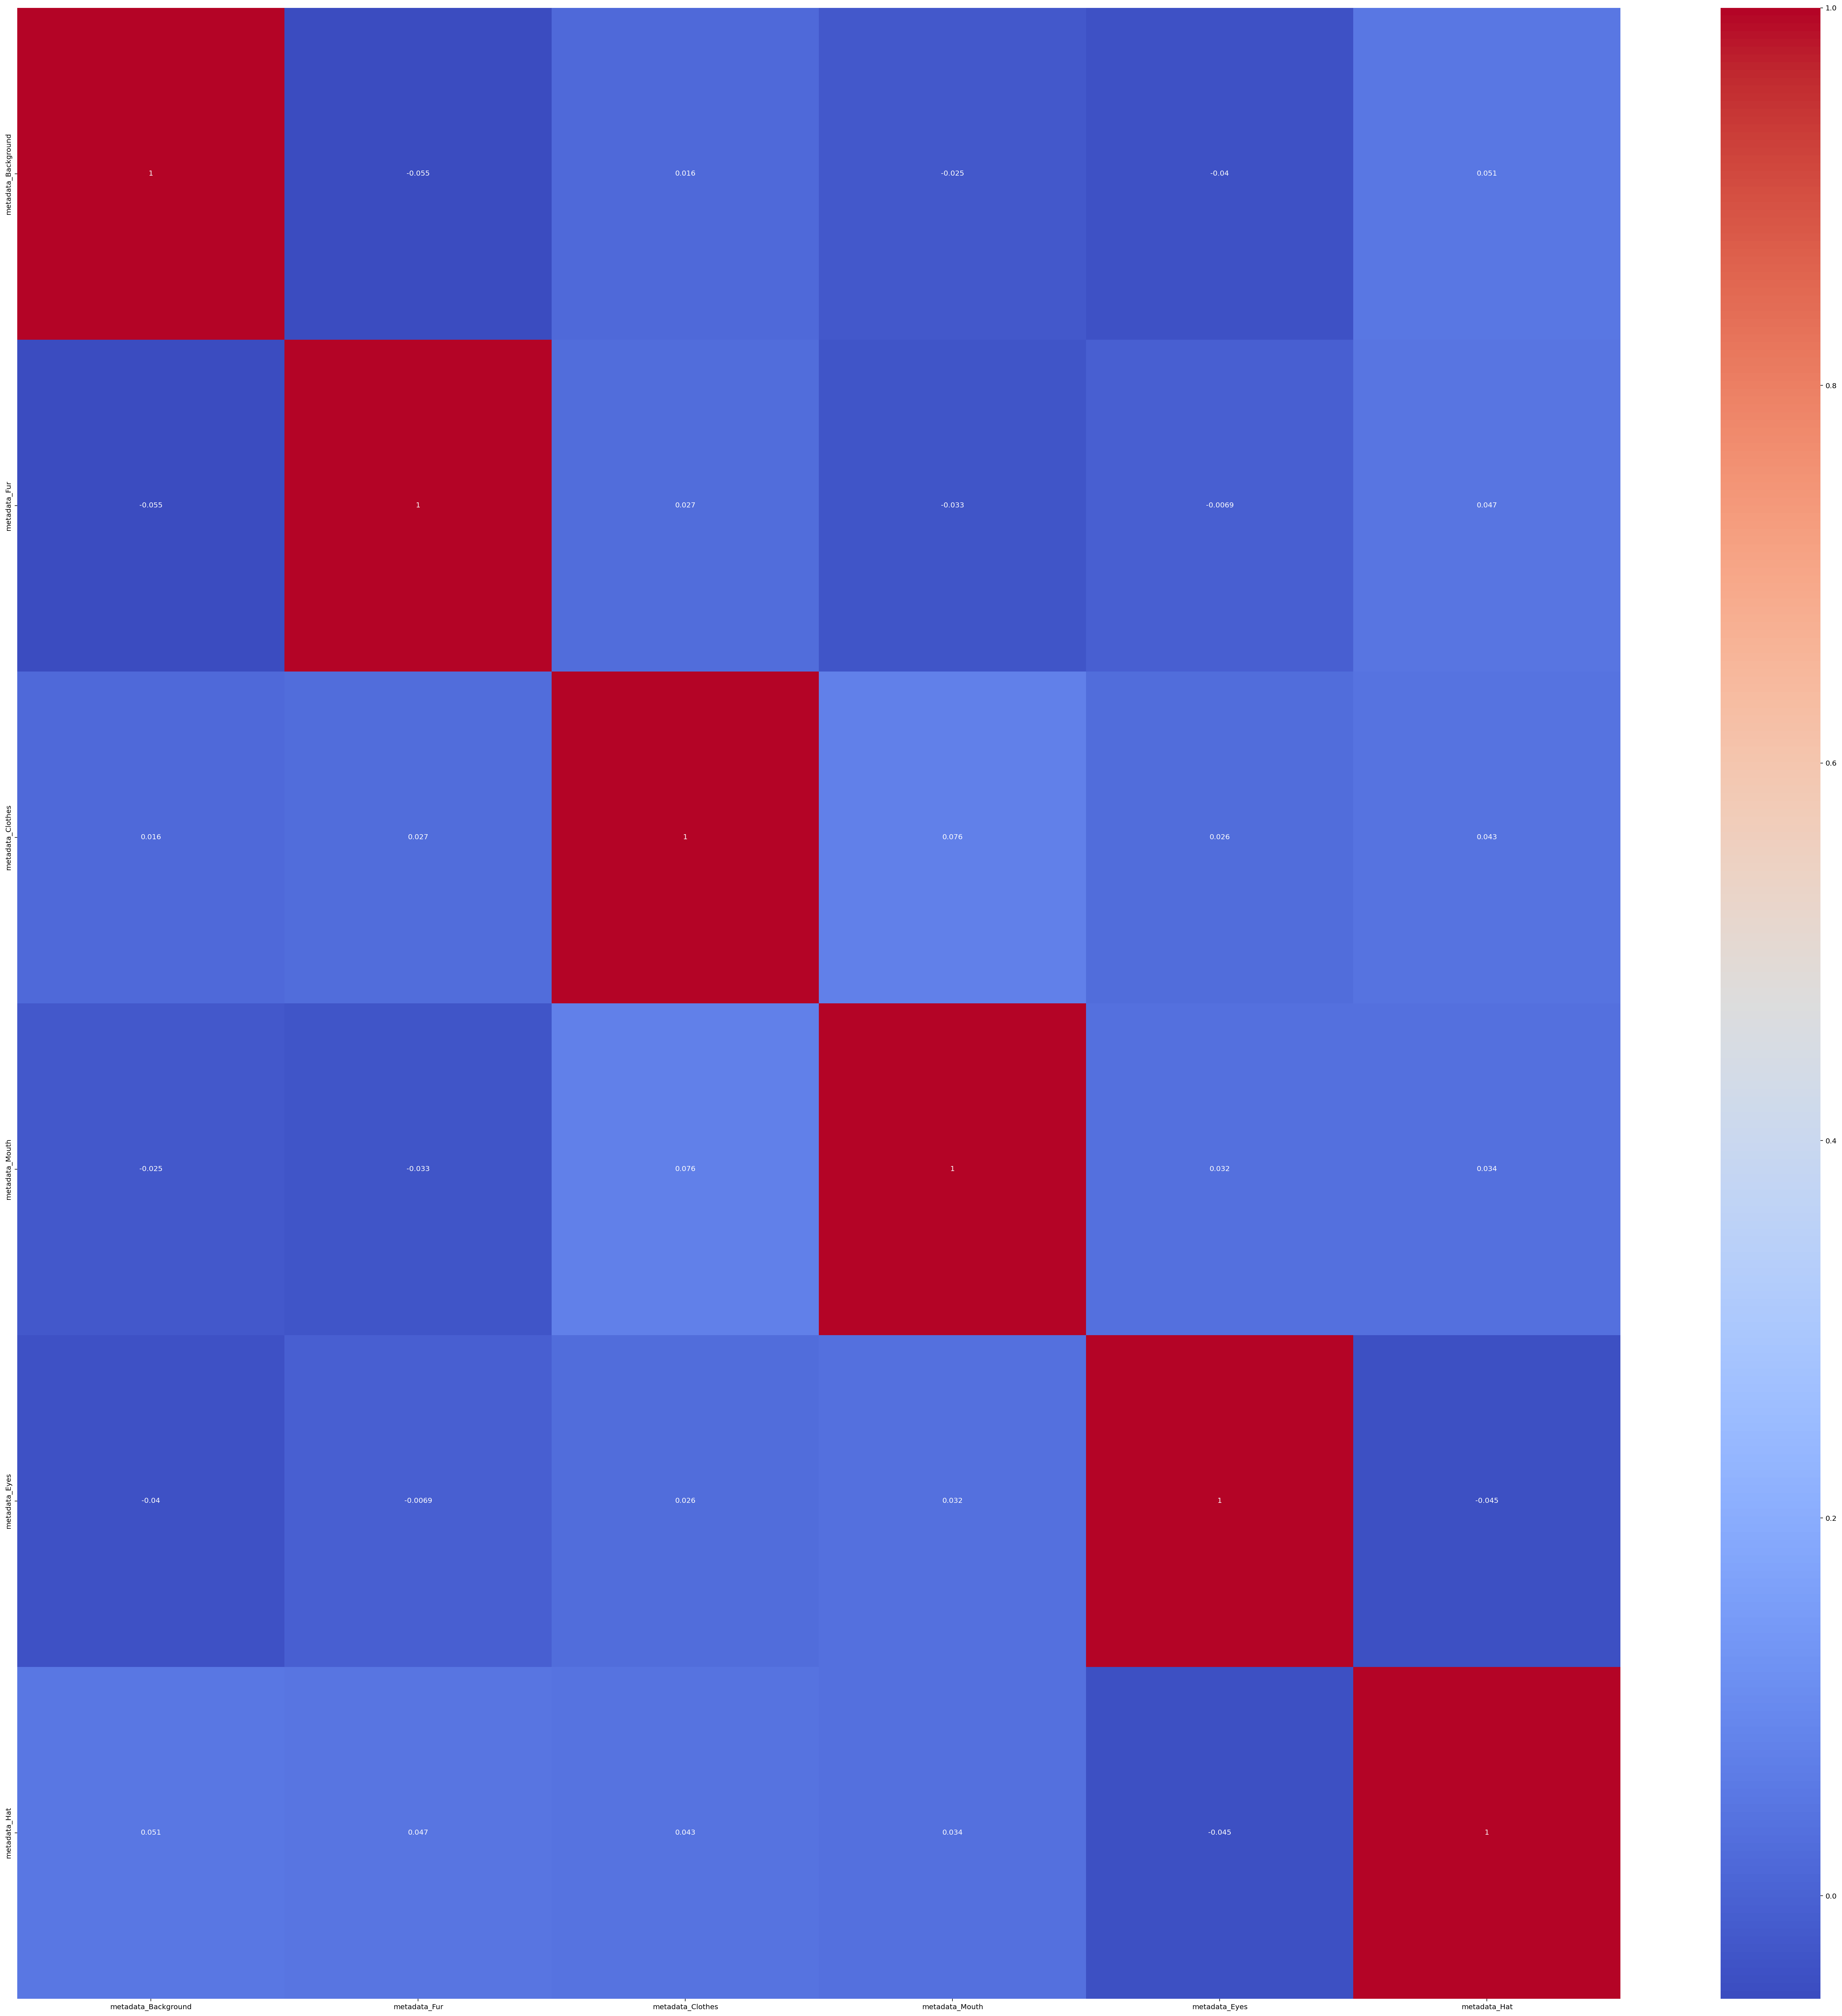

In [10]:
corr_matrix=X_train_variance.corr()
corr_matrix.mask(corr_matrix.abs() < 0.9)
plt.figure(figsize=(50, 50),dpi=144)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [12]:
# n_components=40 as for now and can be changed
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
X_train_reduced = pca.fit_transform(X_train_variance)
X_train_reduced = pd.DataFrame(X_train_reduced)
explained_variance_train = pca.explained_variance_ratio_.sum()
print(explained_variance_train)

1.0


In [13]:
X_test_reduced = pca.transform(X_test_variance)
X_test_reduced = pd.DataFrame(X_test_reduced)
explained_variance_test = pca.explained_variance_ratio_.sum()
print(explained_variance_test)

1.0


In [14]:
#X_train_reduced, X_test_reduced, y_train, y_test
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Create and train the XGBoost regressor
regressor = xgb.XGBRegressor(objective='reg:squarederror')
regressor.fit(X_train, y_train)

# Make predictions using the trained model
y_pred = regressor.predict(X_test)
pred_train_xgb = regressor.predict(X_train)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
# Calculate the mean squared error
mse = mean_squared_error(y_train, pred_train_xgb)
print(f"Mean Squared Error: {mse}")
# Calculate the R-squared score
r2 = r2_score(y_train, pred_train_xgb)
print(f"R-squared: {r2}")

Mean Squared Error: 0.011845205029343615
R-squared: 0.07750362700857949
Mean Squared Error: 2.3430930856986796e-05
R-squared: 0.9982583641347815


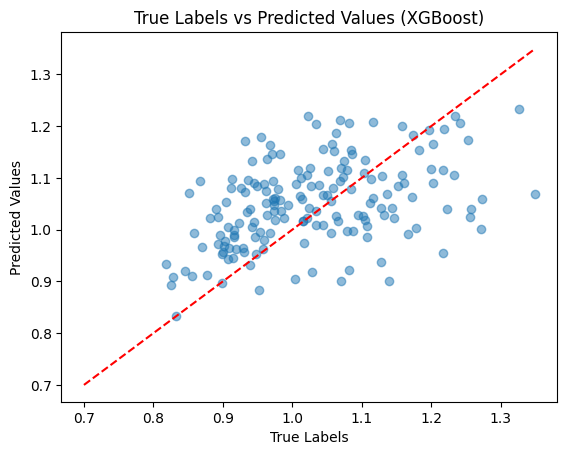

In [15]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values from XGBoost
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values (XGBoost)')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=500,random_state=42)
rf_regressor.fit(X_train_reduced, y_train)
# Make predictions using the trained model
y_pred_rf = rf_regressor.predict(X_test_reduced)
pred_train_rf = rf_regressor.predict(X_train_reduced)
# Calculate the mean squared error
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf}")
# Calculate the R-squared score
r2_rf = r2_score(y_test, y_pred_rf)
print(f"R-squared (Random Forest): {r2_rf}")
mse_rf_train = mean_squared_error(y_train, pred_train_rf)
print(f"Mean Squared Error (Random Forest): {mse_rf_train}")
# Calculate the R-squared score
r2_rf_train = r2_score(y_train, pred_train_rf)
print(f"R-squared (Random Forest): {r2_rf_train}")

Mean Squared Error (Random Forest): 0.011001504085415933
R-squared (Random Forest): 0.1432104728364607
Mean Squared Error (Random Forest): 0.0015938064075639684
R-squared (Random Forest): 0.881531364734458


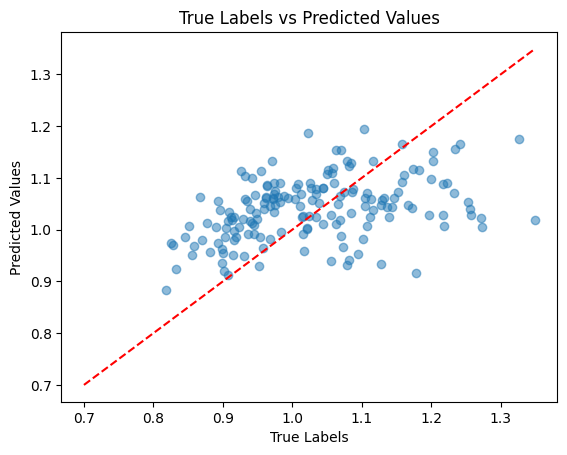

In [17]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred_rf))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()

In [18]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train_reduced, y_train)
y_pred_lr = lr_model.predict(X_test_reduced)
pred_train = lr_model.predict(X_train_reduced)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print(f"Mean Squared Error (Linear Regression): {mse_lr}")


r2_lr = r2_score(y_test, y_pred_lr)
print(f"R-squared (Linear Regression): {r2_lr}")
from sklearn.metrics import mean_squared_error, r2_score
mse_lr_train = mean_squared_error(y_train, pred_train)
print(f"Mean Squared Error on Training Set (Linear Regression): {mse_lr_train}")
r2_lr_train = r2_score(y_train, pred_train)
print(f"R-squared on Training Set (Linear Regression): {r2_lr_train}")


Mean Squared Error (Linear Regression): 0.010524807189334531
R-squared (Linear Regression): 0.18033529731708264
Mean Squared Error on Training Set (Linear Regression): 0.011542725773765836
R-squared on Training Set (Linear Regression): 0.14202191484943416


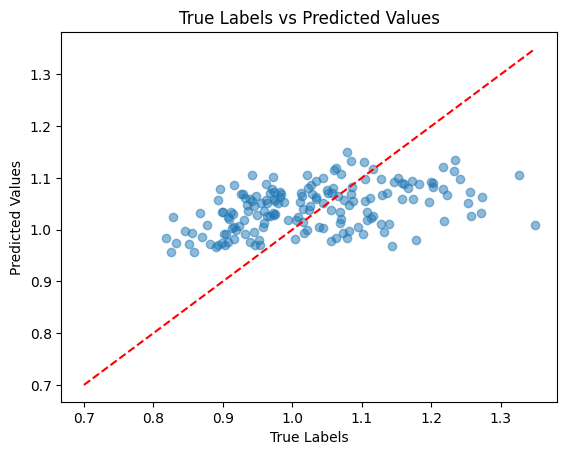

In [19]:
import matplotlib.pyplot as plt

# Create a scatter plot comparing the true labels and the predicted values
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('True Labels vs Predicted Values')

# Add a diagonal line representing a perfect prediction
max_value = max(max(y_test), max(y_pred_lr))
plt.plot([0.7, max_value], [0.7, max_value], color='red', linestyle='--')

# Show the plot
plt.show()